## Transfer Learning from CNN-LSTM


### Method 1 - 2 
- Data preprocess the same way for input
- Only train the second to last +last cnn layer, and freeze the rest


### Bench Marks
**Final Result for Random Forest trained on SOCAT**

Test Set RMSE: 30.56 | Whole Grid Rmse: 42.12


**Final Result for XGBoost trained on SOCAT**

Test Set RMSE:28.43698261274142 | Whole Grid Rmse:37.709863752151215

### Result
**[:-2],*[:-4],'../../models/transfer_CNN_LSTM_FINAL.h5'  BEST PERFORMING**

Test Set RMSE: ~14.75 | Whole Grid RMSE: ~6.7

- resting and training again help lower the rmse score

In [ ]:
tf.keras.backend.clear_session()

In [2]:
def inverse_scale_image_nfp(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    df_tmp = df[df!=0.0]
    
    old_min = np.nanmin(df_tmp)
    old_max = np.nanmax(df_tmp)
    y_pred = arr*(old_max-old_min)/255+old_min
    
    tmp=np.nan_to_num(df[X_index][1:])
    y_true=np.expand_dims(tmp,axis=4)
    y_pred[y_true==0]=0
    return y_true,y_pred

In [3]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

import os
tf.random.set_seed(42)


sys.path.insert(0, '../../src')
from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-03-22 08:30:42.817067: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-03-22 08:31:30.694981: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-22 08:31:30.776179: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-22 08:31:30.958365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-03-22 08:31:30.958413: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-22 08:31:33.030242: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-22 08:31:33.030320: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-0

In [5]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[(y_true != 0) & (y_true != 0.0)]
    y_true = y_true[(y_true != 0) & (y_true != 0.0)]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [6]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"

data,pco2 = preprocess_images_nfp(dir_name)
data_socat, pco2_socat = preprocess_images_nfp(dir_name, socat = True)

val_data,val_pco2 = preprocess_images_nfp(val_dir_name,"035")
val_data_socat,val_pco2_socat = preprocess_images_nfp(val_dir_name,"035",socat=True)



/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [12]:
X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 

y=np.expand_dims(pco2_socat[X_index][1:],axis=4)
X=data_socat[X_index][:-1]

#validation data
val_y=np.expand_dims(val_pco2_socat[X_index][1:],axis=4)
val_X=val_data_socat[X_index][:-1]

print(X.shape, y.shape)

INPUT_SHAPE = X.shape[0]

(418, 3, 180, 360, 6) (418, 3, 180, 360, 1)


In [8]:
from tensorflow.keras.layers import Dense, Reshape, Conv2D, MaxPool2D , Flatten, Input

base_model = tf.keras.models.load_model('../../models/base_CNN_LSTM_new.h5', custom_objects={'custom_rmse':custom_rmse})


2022-03-22 08:32:01.446469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-22 08:32:01.464476: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-22 08:32:01.482281: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-03-22 08:32:01.482357: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-22 08:32:01.482404: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Succ

In [9]:
for index, layer in enumerate(base_model.layers):
    print(index, layer)

0 <tensorflow.python.keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x15550d059be0>
1 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1554ba9ca640>
2 <tensorflow.python.keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x1554b966b8b0>
3 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1554b96c4970>
4 <tensorflow.python.keras.layers.convolutional_recurrent.ConvLSTM2D object at 0x1554d7087070>
5 <tensorflow.python.keras.layers.convolutional.Conv3D object at 0x1554ba9d1310>


In [10]:
for layer in base_model.layers[:-4]:
    layer.trainable = False
    
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 3, 180, 360, 32)   121728    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 3, 180, 360, 32)   73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 3, 180, 360, 32)   8320      
_________________________________________________________________
conv3d (Conv3D)              (None, 3, 180, 360, 1)    865       
Total params: 205,025
Trainable params: 83,105
Non-trainable params: 121,920
_____________________________________________

In [ ]:
# inputs = layers.Input(shape = INPUT_SHAPE, name='inputLayer')
# x = base_model(inputs)
# x = layers.GlobalAveragePooling2D(name='poolingLayer')(x)
# x = layers.Dense(101, name='outputLayer')(x)
# outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

In [13]:
base_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=0.03),
)

model_path="../../models/transfer_CNN_LSTM.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 50
batch_size = 16

In [14]:
history = base_model.fit(
    X,
    y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X, y),
    callbacks=callbacks,
)

2022-03-22 08:33:19.461163: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-22 08:33:19.758161: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz


Epoch 1/50


2022-03-22 08:33:27.298246: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-03-22 08:34:28.771568: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-22 08:34:35.326946: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


27/27 [==============================] - 123s 2s/step - loss: 23.3630 - val_loss: 17.3789
Epoch 2/50
27/27 [==============================] - 34s 1s/step - loss: 14.9442 - val_loss: 31.9874
Epoch 3/50
27/27 [==============================] - 34s 1s/step - loss: 13.9169 - val_loss: 12.8807
Epoch 4/50
27/27 [==============================] - 34s 1s/step - loss: 12.6414 - val_loss: 11.9499
Epoch 5/50
27/27 [==============================] - 34s 1s/step - loss: 11.7604 - val_loss: 11.8902
Epoch 6/50
27/27 [==============================] - 34s 1s/step - loss: 11.4011 - val_loss: 11.0614
Epoch 7/50
27/27 [==============================] - 34s 1s/step - loss: 10.9600 - val_loss: 10.8937
Epoch 8/50
27/27 [==============================] - 34s 1s/step - loss: 11.0900 - val_loss: 10.7330
Epoch 9/50
27/27 [==============================] - 34s 1s/step - loss: 10.9104 - val_loss: 10.4237
Epoch 10/50
27/27 [==============================] - 34s 1s/step - loss: 10.5973 - val_loss: 10.3829
Epoch 11/

Text(0.5, 0, 'epoch')

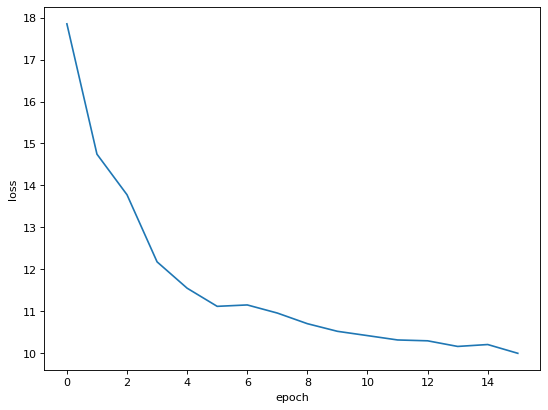

In [15]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

plt.plot(history.history["val_loss"])
plt.ylabel('val_loss')
plt.xlabel('epoch')

### Assessing Performance

In [21]:
best_model = tf.keras.models.load_model('../../models/transfer_CNN_LSTM.h5', custom_objects={'custom_rmse':custom_rmse})

X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 

y=np.expand_dims(pco2_socat[X_index][1:],axis=4)
X=data_socat[X_index][:-1]

predicted_frames=best_model.predict(X,verbose=1)

14/14 [==============================] - 10s 748ms/step


In [22]:
predicted_frames[y==0]=0.0

In [23]:
custom_rmse(y,predicted_frames)

<tf.Tensor: shape=(), dtype=float32, numpy=9.607834>

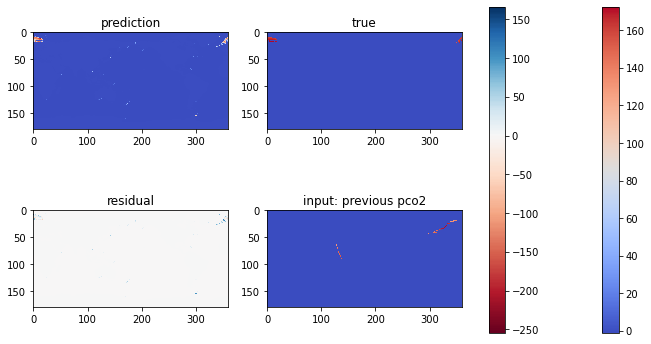

In [24]:
import matplotlib.colors as mcolors
figure, axis = plt.subplots(2, 2,figsize=(12, 6))

d = predicted_frames - y


norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)


img=axis[0][0].imshow(np.flipud(predicted_frames[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true")

diff=np.flipud(np.squeeze(predicted_frames[0][1]-y[0][1]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(X[0][1][:,:,5]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("input: previous pco2")
plt.show()

### Inverse

In [25]:
#chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2_tmp = read_xarray(val_dir_name,"035")

chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2_tmp = read_xarray(dir_name)
y_true,y_pred=inverse_scale_image_nfp(predicted_frames,pco2_tmp.pCO2_socat.data)  

In [26]:
y_pred_tmp = y_pred[:,:1]
y_true_tmp = y_true[:,:1]

# y_pred_tmp = y_pred
# y_true_tmp = y_true


y_pred_tmp = y_pred_tmp[y_true_tmp != 0.0]
y_true_tmp = y_true_tmp[y_true_tmp != 0.0]


print("Scaled back socat RMSE score:")
np.sqrt(np.mean((y_true_tmp-y_pred_tmp)**2))

Scaled back socat RMSE score:


46.27016445924689

In [27]:

custom_rmse(y_pred_tmp,y_true_tmp)




<tf.Tensor: shape=(), dtype=float64, numpy=46.27016445924689>

### full data set


In [28]:

y=np.expand_dims(pco2[X_index][1:],axis=4)
X=data[X_index][:-1]

predicted_frames=best_model.predict(X,verbose=1)
predicted_frames[y==0]=0.0

chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2_tmp = read_xarray(dir_name)
y_true,y_pred=inverse_scale_image_nfp(predicted_frames,pco2_tmp.pCO2.data)  

14/14 [==============================] - 10s 751ms/step


In [30]:
y_pred_tmp = y_pred[:,:1]
y_true_tmp = y_true[:,:1]

custom_rmse(y_pred_tmp,y_true_tmp)



<tf.Tensor: shape=(), dtype=float64, numpy=54.87842427395272>